# Asset Portfolio Management using Deep Reinforcement Learning
----

## 2.0 Download the Data for the Analysis
---
* Data is Downloaded from Yahoo Finance using an API in the FinRL Library
* The 30 Dow Jones Industrial Average tickers for the period from 2009 to 2020 are used
* The data is downloaded and the cleaned data are saved in csv files for use

---


### 2.1 Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from config import config
import matplotlib.pylab as plt

import yfinance as yf
from pandas_datareader import data as pdr

%matplotlib inline

### 2.2 Create Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### 2.3 Download the Dow Jines Industrial Average 30 Stocks

In [3]:
ticker_list = config.DOW_30_TICKER

In [5]:
#Download the data

df = pdr.get_data_yahoo([ticker_list][0], 
                          start='2008-01-01', end="2021-01-01")

In [52]:
data = df.copy()

In [53]:
data = data.stack().reset_index()
data.columns.names = [None]
data = data.drop(['Close'], axis=1)

In [54]:
data.head()

,Date,Symbols,Adj Close,High,Low,Open,Volume
0,2008-01-02,AAPL,6.002815,7.152143,6.876786,7.116786,1.079179e+09
1,2008-01-02,MSFT,26.316847,35.959999,35.000000,35.790001,6.300420e+07
2,2008-01-02,JPM,30.375450,43.790001,42.000000,43.549999,2.212230e+07
3,2008-01-02,RTX,34.651627,48.546257,47.105099,48.231590,6.773748e+06
4,2008-01-02,PG,48.775055,73.589996,71.870003,73.589996,1.225530e+07


In [55]:
data.columns = ['date','tic','close','high','low','open','volume']

In [56]:
data.columns

Index(['date', 'tic', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

### 2.4 Clean the Data

In [57]:
# check for missing values
data.isna().sum()

date      0
tic       0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

In [58]:
# check if all tickers have the same number of data points

no_datasets = []
for i in ticker_list:
    no_data_points = data[data['tic']==i].shape[0]
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)

In [59]:
data_points_df.head()

,0,1
0,AAPL,3274
1,MSFT,3274
2,JPM,3274
3,V,3221
4,RTX,3274


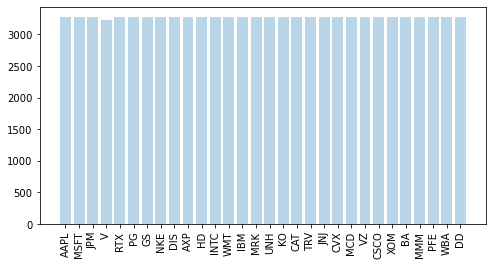

In [60]:
# Plot a bar chart to check that all tickers have same number of data points
plt.subplots(figsize = (8, 4))
plt.bar(data_points_df[0], data_points_df[1],alpha=0.3)
plt.xticks(rotation=90)
plt.show()

In [61]:
# create a list for dates with all ticker data points
date_list = list(data[data['tic']=='V'].date)
# filter with date list
data_filtered = data[data['date'].isin(date_list)]

In [62]:
# check if all tickers have the same number of data points

no_datasets = []
for i in ticker_list:
    no_data_points = data_filtered[data_filtered['tic']==i].shape[0]
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)

In [63]:
data_points_df.head()

,0,1
0,AAPL,3221
1,MSFT,3221
2,JPM,3221
3,V,3221
4,RTX,3221


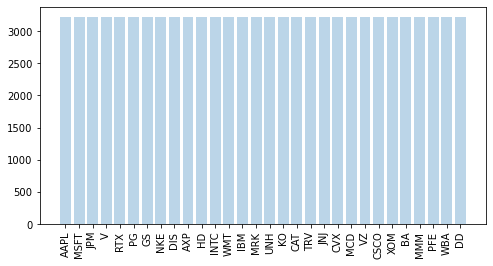

In [64]:
# Plot a bar chart to check that all tickers have same number of data points
plt.subplots(figsize = (8, 4))
plt.bar(data_points_df[0], data_points_df[1],alpha=0.3)
plt.xticks(rotation=90)
plt.show()

In [65]:
data_filtered.head()

,date,tic,close,high,low,open,volume
1537,2008-03-19,AAPL,3.994995,4.796071,4.631071,4.754286,1.010537e+09
1538,2008-03-19,MSFT,21.468340,29.590000,28.620001,29.379999,6.144210e+07
1539,2008-03-19,JPM,30.591537,44.889999,42.439999,43.259998,7.059330e+07
1540,2008-03-19,V,12.927960,17.250000,13.750000,14.875000,7.084860e+08
1541,2008-03-19,RTX,31.819752,44.361233,43.272499,43.813721,9.691947e+06


### 2.5 Save the Data to csv

In [66]:
data_filtered.to_csv('datasets/data.csv', index=False)

### 2.6 Create a Dataset for the Close Prices

In [67]:
# read the data from the saved csv file
df_prices = pd.read_csv('./datasets/data.csv')

In [68]:
# Reset the Index to tic and date
df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()

# Get the list of all the tickers
tic_list = list(set([i for i,j in df_prices.index]))

# Create an empty data frame for the close prices
df_close = pd.DataFrame()

In [69]:
len(tic_list)

30

In [70]:
# Reset the Index to tic and date
df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()

# Get all the Close Prices
df_close = pd.DataFrame()

for ticker in tic_list:
    series = df_prices.xs(ticker).close
    df_close[ticker] = series
    
df_close = df_close.reset_index()

In [71]:
df_close.head()

,date,WBA,TRV,MMM,RTX,DD,KO,V,XOM,CAT,...,JNJ,CSCO,PFE,IBM,MRK,INTC,MCD,BA,NKE,GS
0,2008-03-19,27.162476,33.676067,55.994167,31.819752,34.389133,20.135204,12.927960,54.472538,51.048386,...,44.239494,18.299444,11.740806,80.073196,26.932304,14.305408,36.734047,54.094521,13.067656,138.832825
1,2008-03-20,27.461124,34.677429,54.944336,31.935442,34.455250,20.497879,14.724145,54.840305,51.110714,...,44.580441,18.523792,11.729413,81.024979,27.164101,14.753081,37.254330,55.088783,14.217390,149.790054
2,2008-03-24,28.827457,34.604851,55.409344,32.550919,35.569756,20.544893,13.667027,55.453220,52.640846,...,44.246326,19.174410,11.740806,81.524841,27.721666,15.010838,38.178493,56.186138,14.599930,149.164658
3,2008-03-25,28.379486,34.655636,55.648911,32.467625,35.758652,20.622128,14.472454,54.969315,53.063187,...,44.014500,19.256668,11.837650,80.778450,27.984785,15.105799,38.472866,55.898911,14.449876,149.790054
4,2008-03-26,28.342155,34.503265,55.423466,32.213104,35.711433,20.534811,14.634912,55.653210,53.561695,...,44.116768,18.531269,11.786383,80.052643,28.003590,14.827696,38.062122,56.193504,14.006041,146.329437


In [72]:
# Get Discriptive statistics
df_close.describe().T

,count,mean,std,min,25%,50%,75%,max
WBA,3221.0,47.043933,19.200297,16.068489,27.956087,46.849823,65.471779,83.684784
TRV,3221.0,80.363329,35.502856,22.419786,44.946720,80.867004,112.105247,148.982651
MMM,3221.0,116.107805,51.687989,30.443624,66.424507,119.382149,158.569763,234.984451
RTX,3221.0,53.509660,17.610427,17.821968,38.354401,56.164131,64.957855,95.950813
DD,3221.0,52.008420,21.885500,6.327086,33.657009,52.710583,66.831680,102.729507
KO,3221.0,32.765026,10.421298,12.994798,24.698708,33.143414,40.166832,58.140400
V,3221.0,71.888316,57.780707,9.739301,20.210981,52.453350,105.869308,218.729996
XOM,3221.0,60.224762,10.805761,29.542191,51.125416,63.673279,68.557472,78.561218
CAT,3221.0,82.578822,34.623850,15.837968,62.192520,73.701324,108.851944,182.210007
PG,3221.0,68.880448,25.245768,30.718750,47.686821,65.842461,78.517113,144.279999


In [73]:
# Save the Close Price datase

df_close.to_csv('datasets/close_prices.csv', index=False)

In [74]:
# Close prices for all the stocks
df_close_full_stocks = df_close

In [75]:
df_close_full_stocks.head()

,date,WBA,TRV,MMM,RTX,DD,KO,V,XOM,CAT,...,JNJ,CSCO,PFE,IBM,MRK,INTC,MCD,BA,NKE,GS
0,2008-03-19,27.162476,33.676067,55.994167,31.819752,34.389133,20.135204,12.927960,54.472538,51.048386,...,44.239494,18.299444,11.740806,80.073196,26.932304,14.305408,36.734047,54.094521,13.067656,138.832825
1,2008-03-20,27.461124,34.677429,54.944336,31.935442,34.455250,20.497879,14.724145,54.840305,51.110714,...,44.580441,18.523792,11.729413,81.024979,27.164101,14.753081,37.254330,55.088783,14.217390,149.790054
2,2008-03-24,28.827457,34.604851,55.409344,32.550919,35.569756,20.544893,13.667027,55.453220,52.640846,...,44.246326,19.174410,11.740806,81.524841,27.721666,15.010838,38.178493,56.186138,14.599930,149.164658
3,2008-03-25,28.379486,34.655636,55.648911,32.467625,35.758652,20.622128,14.472454,54.969315,53.063187,...,44.014500,19.256668,11.837650,80.778450,27.984785,15.105799,38.472866,55.898911,14.449876,149.790054
4,2008-03-26,28.342155,34.503265,55.423466,32.213104,35.711433,20.534811,14.634912,55.653210,53.561695,...,44.116768,18.531269,11.786383,80.052643,28.003590,14.827696,38.062122,56.193504,14.006041,146.329437


In [76]:
%store df_close_full_stocks

Stored 'df_close_full_stocks' (DataFrame)


In [77]:
ticker_list = df_close_full_stocks.columns

In [78]:
print(ticker_list)

Index(['date', 'WBA', 'TRV', 'MMM', 'RTX', 'DD', 'KO', 'V', 'XOM', 'CAT', 'PG',
       'AXP', 'WMT', 'MSFT', 'VZ', 'JPM', 'UNH', 'DIS', 'HD', 'AAPL', 'CVX',
       'JNJ', 'CSCO', 'PFE', 'IBM', 'MRK', 'INTC', 'MCD', 'BA', 'NKE', 'GS'],
      dtype='object')
